# LRP over MNIST

#### Imports

In [1]:
#python 2 and 3 comptibility
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

#enables acces to parent folder
import os
import sys
sys.path.append("..")

#other imports
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

#MNIST import
from tensorflow.examples.tutorials.mnist import input_data

#modules import
import modules.sequential32 as sequential32
import modules.linear32 as linear32
import modules.convolution32 as convolution32
import modules.maxpool32 as maxpool32
import modules.avgpool32 as avgpool32
from modules.heatmap import plot_relevances
import modules.utils as utils


#print of plots within notebook
%matplotlib inline

#### Execute if MNIST haven't been downladed
MNIST dataset weights approx. 12 MB. If it isn't previously downloaded on directory 'data/MNIST', it will be automatically downladed with next code cell.

In [2]:
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


#### Alternatively you can give a path to previously downloaded MNIST
[only execute if previous cell wasn't]

In [2]:
#MNIST path
from tensorflow.examples.tutorials.mnist import input_data
data_dir = '/home/tesla/Desktop/MNIST_data/data'
data = input_data.read_data_sets(data_dir, one_hot=True)

Extracting /home/tesla/Desktop/MNIST_data/data/train-images-idx3-ubyte.gz
Extracting /home/tesla/Desktop/MNIST_data/data/train-labels-idx1-ubyte.gz
Extracting /home/tesla/Desktop/MNIST_data/data/t10k-images-idx3-ubyte.gz
Extracting /home/tesla/Desktop/MNIST_data/data/t10k-labels-idx1-ubyte.gz


#### Print set lenghts

In [19]:
print("Number of sample in each set of MNIST:")
print("Training-set:\t\t{}".format(len(data.train.labels)))
print("Test-set:\t\t{}".format(len(data.test.labels)))

Number of sample in each set of MNIST:
Training-set:		55000
Test-set:		10000


#### Instantiatite network model

This consider a pretreined model. To be loaded, weights must be in a 'weights_MNIST_MaxPool/' folder, relative to this notebook.

In [3]:
path_weights = 'weights_MNIST_MaxPool/'
def nn():
    return sequential32.Sequential([convolution32.Convolution(kernel_size=5, output_depth=32, input_depth=1,
                                   input_dim=28, act ='relu',
                                   stride_size=1, pad='SAME', param_dir=path_weights+'CNN1'),
                       maxpool32.MaxPool(),

                       convolution32.Convolution(kernel_size=5,output_depth=64, stride_size=1,
                                   act ='relu', pad='SAME', param_dir=path_weights+'CNN2'),
                       maxpool32.MaxPool(),
                       
                       linear32.Linear(1024, act ='relu', param_dir=path_weights+'FC1'),

                       linear32.Linear(10, act ='linear', param_dir=path_weights+'FC2')])

#### Model I/O

In [11]:
#Dropout placeholder
keep_prob = tf.placeholder(tf.float32, name='keep-prob')

#Input place holders
with tf.name_scope('input'):
        #stetched image
        x = tf.placeholder(tf.float32, [None, 784], name='x-input')
        #target label
        y_ = tf.placeholder(tf.float32, [None, 10], name='y-input')
  
        #reshape input as image tensor with an undifined batch size (-1)
        inp = tf.reshape(x, [-1, 28, 28, 1])

#Model instance
with tf.variable_scope('model'):
        #instanciate model
        net = nn()

        #feed-forward method and get score output. This iterates through layer in net object of class Sequiential
        score = net.forward(inp)

        #pass scores through softmax for network output ([0,1] probability)   
        y = tf.nn.softmax(score)

        #predicted classes
        y_pred_cls = tf.argmax(y, 1)

        #true classes
        y_true_cls = tf.argmax(y_, 1)

Forward Pass ... 
------------------------------------------------- 
input:: [None, 28, 28, 1]
conv2d_22:: [None, 28, 28, 32]
maxpool_23:: [None, 14, 14, 32]
conv2d_24:: [None, 14, 14, 64]
maxpool_25:: [None, 7, 7, 64]
linear_26:: [None, 1024]
linear_27:: [None, 10]
softmax:: [None, 10]

------------------------------------------------- 


#### Accuracy measurement

In [13]:
with tf.name_scope('accuracy'):  
        #performance measures

        #compare predictions
        with tf.name_scope('correct_prediction'):
            correct_prediction = tf.equal(y_pred_cls, y_true_cls)
        #get accuracy
        with tf.name_scope('accuracy'):
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
accuracy_sum = tf.summary.scalar('accuracy', accuracy)

#### Selection of class to be propagated
In this section we consider that network's raw output scores (output right before softmax layer) is propagated with LRP.

Whole output scores can be propagated, to see contribution from each class to the relevance heatmap at input, or just a single class output score can be propagated to know which input pixels are relevant to that class. This last option means to leave class score index value and every other value of the output score vector as 0. 
    
Mainly, there are 3 LRP propagation options:
1. Propagate full output score of the network which means that input heatmap will have negative and positive contributions from all classes 
2. Propagate predictied score, which will generate a heatmap with predicted class specific relevance. This means that the heatmap will depict which pixels are important for the classification made.
3. When the model missclassifies you can propagate true class score, and heatmap genereted will show in blue which pixels lower the classification score to that output.

Alternatively, softmax output can be LRP back propagated, but there is no consensus on what value should be propagated, a draw back of prapagating softmax is that negative score are turned to positive.


In [18]:
with tf.variable_scope('output_relevance'):
    
        #mask for predicted classes LRP
        y_pred_OH = tf.one_hot(indices=y_pred_cls, depth=10)
        #model prediction output_relevance
        y_rel_pred=score*y_pred_OH
        
        #true class output_relevance
        y_rel_true=score*tf.to_float(y_true_cls)
        
        #with this variable we can choose to propagate predicted score as 'y_rel_pred',
        #true class score as 'y_rel_true' or just the whole output score as 'score'
        y_rel_model=y_rel_pred
        
        #To LRP backpropagate softmax aoutput, simply replace 'score' variable by 'y' 

### Set LRP parameters

Here LRP parameters can be chosen, such as propagation rule that can be:

1. $\epsilon$
2. $\alpha \beta$

And asociated parameters of propagation.

#### Epsilon rule

This propagation rule tries to directly propagate relevance to previous layer by using simple propagation rule as:

\begin{equation}
R_{i\leftarrow j}^{(l,l+1)}=\frac{z_{ij}}{z_j}R_j^{(l+1)}.
\label{eq:prop_rule}
\end{equation}

But numerical insteabilities take place due $z_j$ taking very small values that can be round to 0. So an stibilizer term $\epsilon$ is introduced, thus the $\epsilon$-rule equation is:

\begin{equation}
R_{i\leftarrow j}^{(l,l+1)}=\frac{z_{ij}}{z_j+\epsilon \, sign(z_j)}R_j^{(l+1)}.
\label{eq:prop_rule_e}
\end{equation}


Where $\epsilon$ should take small values (ex: $10^{-12}$) to not interfere with relevance propagated.
#### Alpha-beta rule

This propagation rule separates calculation of positive from negative relevance, and adds them together at the end. Because of this separation of positive and negative values, numerical inestabilities rarely happen and we can avoid the stabilizer term intriduced above, thus having a propagation rule that sticks with the layer-wise conservation principle of LRP. Its equation corresponds to:

\begin{equation}
R_{i\leftarrow j}^{(l,l+1)}=\left(\alpha\,\frac{z_{ij}^+}{z_j^+}+\beta\,\frac{z_{ij}^-}{z_j^-}\right)R_j^{(l+1)}.
\label{eq:prop_rule_ab}
\end{equation}

where $ \alpha+\beta = 1 $

When choosing $\alpha=1$ and $\beta=0$ we have the LRP-$\alpha_1\beta_0$ rule that __only__ propagates positive relevances to the input.

This rule is implemented by choosing $\alpha$ value, and $\beta=1-\alpha$ value. 

In [24]:

with tf.variable_scope('relevance'):

    
        #alpha-beta LRP
        relevance_method_ab='alphabeta'

        #alpha:1 - beta:0
        relevance_param_a1b0 = 1
        #alpha: 2 - beta:-1
        relevance_param_a2b1 = 2
        
        #epsilon LRP
        relevance_method_e='epsilon'
        
        #epsilon:1e-12
        relevance_param_e012 = 1e-12
        #epsilon:0.01
        relevance_param_e01 = 0.01
        #epsilon:1
        relevance_param_e1 = 1
        #epsilon:100
        relevance_param_e100 = 100
        
        #choose propagation rule that will take place
        #LRPa1b0 = net.lrp(y_rel_model, relevance_method_ab, relevance_param_a1b0)
        LRPa2b1 = net.lrp(y_rel_model, relevance_method_ab, relevance_param_a2b1)
        
        #LRPe012 = net.lrp(y_rel_model, relevance_method_e, relevance_param_e012)
        #LRPe01 = net.lrp(y_rel_model, relevance_method_e, relevance_param_e01)
        #LRPe1 = net.lrp(y_rel_model, relevance_method_e, relevance_param_e1)
        #LRPe100 = net.lrp(y_rel_model, relevance_method_e, relevance_param_e100)


Computing LRP ... 
------------------------------------------------- 
linear_27:: [None, 1024]
linear_26:: [None, 3136]
maxpool_25:: [None, 14, 14, 64]
conv2d_24:: [None, 14, 14, 32]
maxpool_23:: [None, 28, 28, 32]
conv2d_22:: [None, 28, 28, 1]

------------------------------------------------- 


#### Init Tensorflow session and variables

In [25]:
config = tf.ConfigProto(allow_soft_placement = True)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

#### Functions to feed model with data
Generates proper functions to construct dictionary that will be feed to model graph. Define batch, labels and dropout.

There is the option to feed the model with a batch of MNIST, or feed it with a ten digits example.

__Remember:__ Images pixels are 0 centered in values [-1,1]

In [26]:
##Get MNIST Data to feed model. You can choose to feed a train batch or the whole test set 
def feed_dict(mnist, train, batch_s=None):
    if train:
        xs, ys = mnist.train.next_batch(batch_s)
        k = dropout
    else:
        xs, ys = mnist.test.images, mnist.test.labels
        k = 1.0
    return (2*xs)-1, ys, k
    
##Get certain data examples to feed model
def feed_dictEx():
    xs = np.load('numbers_images/numbers_examples.npy')
    #construct one hot labels
    a = np.array([0,1,2,3,4,5,6,7,8,9])
    b = np.zeros((10, 10))
    b[np.arange(10), a] = 1
    ys=b
    #dropour
    k = 1.0
    return xs, ys, k

#### Check accuracy of the pre-trained model
In this block of code whole test set images and labels will be loaded to memory, so if you don't have much RAM only skip next block (around 8GB of RAM are needed).

In [30]:
#get test set
d_t = feed_dict(data, train=False)
#create dictionary
inp_t = {x:d_t[0], y_:d_t[1], keep_prob:d_t[2]}
#get accuracy
acc = sess.run(accuracy, feed_dict=inp_t)

#print accuracy
num_test = len(data.test.images)
correct_sum = int(acc*num_test)
msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
print(msg.format(acc, correct_sum, num_test))

Accuracy on Test-Set: 99.3% (9926 / 10000)


#### Show numbers to test LRP
example number will be ploted

Predicted classes for examples:
 [0 1 2 3 4 5 6 7 8 9]


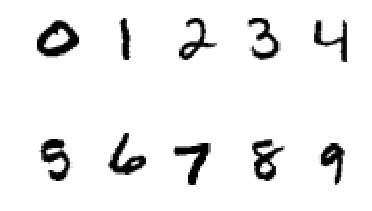

In [31]:
d_ex = feed_dictEx()
inp_ex = {x:d_ex[0], y_:d_ex[1], keep_prob:d_ex[2]}

predEx = sess.run(y_pred_cls, feed_dict=inp_ex)
print("Predicted classes for examples:\n", predEx)

utils.showExamples(d_ex[0])

## LRP Examples

Lets take arbitrary numbers 2,3,4,7 to perform LRP, and define a function to plot them

In [38]:
inp_param = {x:d_ex[0][[2,3,4,7],:], y_:d_ex[1][[2,3,4,7],:], keep_prob:d_ex[2]}

#function to plot MNISt (28x28, single channel image) LRP
def plotLRP(rel, samples, titles, prop=None, show_prop=False):
    numberOfExamples=samples.shape[0]
    numbers = samples.reshape([numberOfExamples,28,28,1])
    numbers = (numbers + 1)/2.0
    cols=len(rel)
    
    for j in range(numberOfExamples):
        fig, ax = plt.subplots(nrows=1, ncols=cols)
        for i in range(cols):
            relevance = rel[i]#[0:numberOfExamples,2:30,2:30,0]
            img_sum=plot_relevances(relevance.reshape([numberOfExamples,28,28,1]), numbers)
            plt.subplot(1, cols, i+1)
            plt.imshow(img_sum[j,:,:,:], interpolation='nearest')
            plt.axis('off')
            plt.title(titles[i])
        if(show_prop):
            print("Propagated class:", prop[j])
        plt.show()

##### Alpha-Beta 

LRP-$\alpha_2\beta_1$ parameters will be considered (You can define any rule and parameters in **_Set LRP parameters_** section) 

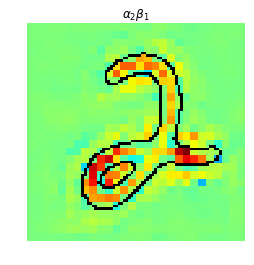

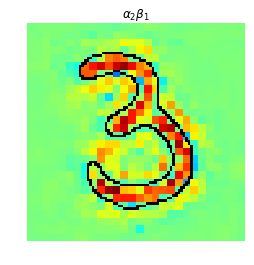

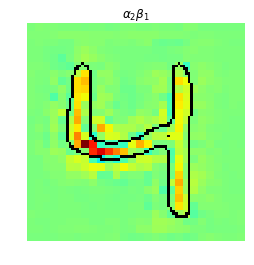

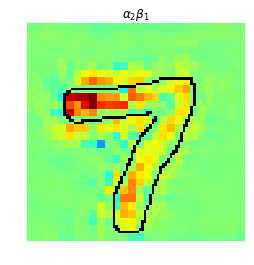

In [40]:
#get relevances over MNIST examples
rel_a2b1 = sess.run(LRPa2b1, feed_dict=inp_param)

#titles for plots
titles=[r"$\alpha_2\beta_1$"]
            
#plot relevances
plotLRP([rel_a2b1], inp_param.get(x), titles)     

# TODO: 
# -Test set by batches for getting accuracy
# -TB